In [796]:
%run feature_extraction.ipynb

c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


1.6597412693274927e-110
4.2552940390803975e-123
Cosine similarity between 'لقاح' and 'كورونا' - CBOW :  0.9989086
Cosine similarity between 'لقاح' and 'صيفي' - CBOW :  0.77969635
Cosine similarity between 'لقاح' and 'كورونا' - Skip Gram :  0.84706306
Cosine similarity between 'لقاح' and 'صيفي' - Skip Gram :  0.6795748


In [797]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import tqdm
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import torch

In [798]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [799]:
train_1=pd.read_pickle('output/train_3_original.pkl')

In [800]:
dev_1=pd.read_pickle('output/dev_1_original.pkl')

In [801]:
train_1.head(10)


,text,category,stance,tokens
3,#تركيا.. وزير الصحة فخر الدين قوجة يتلقى أول ج...,celebrity,2,"[وزر, صحة, فخر, دين, قوج, لقى, اول, جرع, لقح, ..."
4,وئام وهاب يشتم الدول الخليجية في كل طلة اعلامي...,personal,1,"[وئم, وهب, شتم, دول, خلج, طلة, علم, تسف, علي, ..."
5,"لقاح #كورونا في أميركا.. قلق متزايد من ""التوزي...",info_news,1,"[لقح, امر, قلق, زايد, وزع, عدل]"
5,"لقاح #كورونا في أميركا.. قلق متزايد من ""التوزي...",info_news,1,"[لقح, امر, قلق, زايد, وزع, عدل]"
5,"لقاح #كورونا في أميركا.. قلق متزايد من ""التوزي...",info_news,1,"[لقح, امر, قلق, زايد, وزع, عدل]"
6,لبنان اشترى مليونان لقاح امريكي اذا شلنا يلي ع...,info_news,2,"[لبن, شرى, لين, لقح, امر, اذا, شلن, يلي, عمر, ..."
9,دعبول حضرتك منو انت وتطلب من قائد دولة إسلامية...,info_news,2,"[دعبول, حضر, منو, انت, طلب, قئد, دول, سلم, لقح..."
10,مات 23 شخص في النرويج بعد تلقي لقاح #COVID19....,info_news,0,"[مات, شخص, روج, تلق, لقح, بوس]"
10,مات 23 شخص في النرويج بعد تلقي لقاح #COVID19....,info_news,0,"[مات, شخص, روج, تلق, لقح, بوس]"
10,مات 23 شخص في النرويج بعد تلقي لقاح #COVID19....,info_news,0,"[مات, شخص, روج, تلق, لقح, بوس]"


In [802]:
train_1.loc[:,"tokens"]

3       [وزر, صحة, فخر, دين, قوج, لقى, اول, جرع, لقح, ...
4       [وئم, وهب, شتم, دول, خلج, طلة, علم, تسف, علي, ...
5                         [لقح, امر, قلق, زايد, وزع, عدل]
5                         [لقح, امر, قلق, زايد, وزع, عدل]
5                         [لقح, امر, قلق, زايد, وزع, عدل]
                              ...                        
6983                                 [يجب, طعم, قلل, اصب]
6984                 [وبء, خطر, كرة, رضي, كورو, امر, خطط]
6984                 [وبء, خطر, كرة, رضي, كورو, امر, خطط]
6985                                [جرع, ولى, لقح, كورو]
6986        [حظر, لقح, غرب, صدد, جزة, جرب, لقح, كوب, يرن]
Name: tokens, Length: 3000, dtype: object

In [803]:
train_1.loc[:,"tokens"]
# lables
train_1.loc[:,"stance"]
train_1.loc[:,"category"]

3       celebrity
4        personal
5       info_news
5       info_news
5       info_news
          ...    
6983    info_news
6984       others
6984       others
6985    info_news
6986    info_news
Name: category, Length: 3000, dtype: object

In [804]:
def edit_categories(x):
    if x == 'info_news':
        return 0
    elif x == 'celebrity':
        return 1
    elif x == 'plan':
        return 2
    elif x == 'requests':
        return 3
    elif x == 'rumors':
        return 4
    elif x == 'advice':
        return 5
    elif x == 'restrictions':
        return 6
    elif x == 'personal':
        return 7
    elif x == 'unrelated':
        return 8
    elif x == 'others':
        return 9
    else:
        return -1

In [805]:
def get_max_padding(data_train):
    max_len = 0
    # print(type(data_train))
    for i in range(len(data_train)):      
        max_len =max(max_len,len (data_train[i]))
    return  max_len

In [806]:
# max_len=get_max_padding(train_1.loc[:,"tokens"])

In [807]:
def process_data(sentences,stance,category,max_len):   
    pad_words = ["باد"]
    for i in range(len(sentences)):
        if len(sentences[i] )< max_len:
            pad = ["باد"]*(max_len- len(sentences[i]))
            sentences[i] = sentences[i]+ pad
    category =category.apply(edit_categories)
    return sentences,category,stance



In [808]:
sentences_train,stance_train,category_train =train_1.loc[:,"tokens"],train_1.loc[:,"stance"],train_1.loc[:,"category"].apply(edit_categories)

In [809]:
sentences_dev,stance_dev,category_dev =dev_1.loc[:,"tokens"],dev_1.loc[:,"stance"],dev_1.loc[:,"category"].apply(edit_categories)

In [810]:
# train_1.loc[:,"tokenized"][1]
train_1.loc[:,"text"]

3       #تركيا.. وزير الصحة فخر الدين قوجة يتلقى أول ج...
4       وئام وهاب يشتم الدول الخليجية في كل طلة اعلامي...
5       لقاح #كورونا في أميركا.. قلق متزايد من "التوزي...
5       لقاح #كورونا في أميركا.. قلق متزايد من "التوزي...
5       لقاح #كورونا في أميركا.. قلق متزايد من "التوزي...
                              ...                        
6983    #الاتحاد_الدولي_لمكافحه_العدوي: يجب تطعيم 70% ...
6984    الوباء الاخطر على الكرة الأرضية ليس كورونا <LF...
6984    الوباء الاخطر على الكرة الأرضية ليس كورونا <LF...
6985    الجرعة الاولى من لقاح كورونا 👌 https://t.co/L2...
6986    بعد حظر #خامنئي اللقاحات الغربية.. #طهران بصدد...
Name: text, Length: 3000, dtype: object

In [811]:
print(len(sentences_train),len(category_train),len(stance_train))

3000 3000 3000


In [812]:
print(len(sentences_dev),len(category_dev),len(stance_dev))

1000 1000 1000


In [813]:
print(type(sentences_train))

<class 'pandas.core.series.Series'>


In [814]:
print(corpus[0])

بيل غيتس يتلقى لقاح تصوير الابرة السيرنجة الدواء لابس بولو صيفي عز الشتاء يقول ان احدى مزايا عمر ال عاما انه مؤهل للحصول اللقاح يعنى يحتاج اللقاح عمره اصغر


In [815]:
sentences_train=sentences_train
sentences_dev= sentences_dev
new_sentences_train=[]
new_sentences_dev=[]
for sentence in sentences_train:
    new_sentences_train.append(' '.join(sentence))
for sentence in sentences_dev:
    new_sentences_dev.append(' '.join(sentence))


In [816]:
def preprocessing_tf_ifd(sentences):
    new_sentences=[]
    for sentence in sentences:
        new_sentences.append(' '.join(sentence))
    return new_sentences


In [817]:
new_sentences_train=preprocessing_tf_ifd(sentences_train)

In [818]:
dict_res_train,tfIdf=get_TF_IDF(new_sentences_train)
# print(dict_res_train)
td_idf_train=assign_tf_idf(sentences_train,dict_res_train)

c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [819]:
new_sentences_dev=preprocessing_tf_ifd(sentences_dev)
dict_res_dev,tfIdf=get_TF_IDF(new_sentences_dev)
# print(dict_res_train)
td_idf_dev=assign_tf_idf(sentences_dev,dict_res_dev)

In [820]:
prob_dev = convert_ngrams_probablities( 2,new_sentences_dev)
prob_train = convert_ngrams_probablities( 2,new_sentences_train)

In [821]:
def embeddings(max_len,data): #aravert embeddings
    data =data.tolist()
    new_data=[]
    len_embeddings_one_wprd =0
    for value in data:
        for word in value :
            len_embeddings_one_wprd= len(word)
            break

    # 3 words
    # 5 words
    # word => vector
    # padding vector??
    for sentence in data: # sentences 
        if len(sentence)< max_len:
            n_paddings = (max_len- len(sentence))
            paddings = [0]*len_embeddings_one_wprd
            sentence.append()

           
          
        elif len(sentence)== max_len:
            sentences = sentences.tolist()
        else:
            print("error")
        new_data.append(sentences)
        
    return new_data


In [822]:
feature_train =[td_idf_train,prob_train]
feature_dev = [td_idf_dev, prob_dev]

In [823]:
print(len(feature_train))

2


In [824]:
feature_train = np.transpose(np.array(feature_train))
feature_dev = np.transpose(np.array(feature_dev))


In [825]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from  matplotlib import pyplot 

In [826]:
feature_train.shape

(3000, 2)

In [827]:
# Boost 100 weak decision trees

n_estimators = [50, 100, 150, 200, 250, 300, 350]
train_scores=[]
test_scores=[]
for val in n_estimators:
    model = RandomForestClassifier(n_estimators=val)
    model = model.fit(feature_train, stance_train)
    predictions = model.predict(feature_dev)
    acc = {metrics.accuracy_score(stance_dev, predictions) * 100}
    print(f" Model Accuracy is {acc}")
    print(metrics.classification_report(stance_dev,predictions))
    train_score = accuracy_score(stance_train,model.predict(feature_train))
    train_scores.append(train_score)
    test_score = accuracy_score(stance_dev,model.predict(feature_dev))
    test_scores.append(test_score)

 Model Accuracy is {18.8}
              precision    recall  f1-score   support

           0       0.08      0.13      0.10        70
           1       0.13      0.79      0.22       126
           2       0.73      0.10      0.18       804

    accuracy                           0.19      1000
   macro avg       0.31      0.34      0.16      1000
weighted avg       0.61      0.19      0.18      1000

 Model Accuracy is {18.9}
              precision    recall  f1-score   support

           0       0.07      0.13      0.09        70
           1       0.13      0.78      0.22       126
           2       0.73      0.10      0.18       804

    accuracy                           0.19      1000
   macro avg       0.31      0.34      0.16      1000
weighted avg       0.60      0.19      0.18      1000

 Model Accuracy is {18.9}
              precision    recall  f1-score   support

           0       0.08      0.13      0.10        70
           1       0.13      0.78      0.22       1

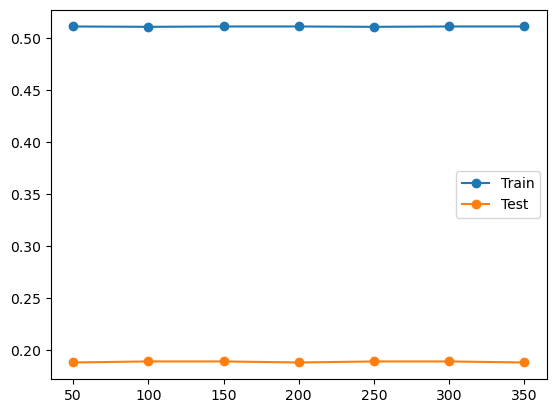

In [828]:
# plot of train and test scores vs tree depth
pyplot.plot(n_estimators, train_scores, '-o', label='Train')
pyplot.plot(n_estimators, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

In [829]:
cm = confusion_matrix(stance_dev, predictions)


In [830]:
print(cm)

[[  9  43  18]
 [ 16  99  11]
 [ 94 630  80]]


In [831]:
# Boost 100 weak decision trees
model = RandomForestClassifier(n_estimators=100)
#GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)

model = model.fit(feature_train, category_train)

In [832]:
predictions = model.predict(feature_dev)
acc = {metrics.accuracy_score(category_dev, predictions) * 100}
train_score = accuracy_score(category_train,model.predict(feature_train))
print("train accuarcy", train_score)
print(f" Model Accuracy is {acc}")

train accuarcy 0.5603333333333333
 Model Accuracy is {51.300000000000004}


In [833]:
print(metrics.classification_report(category_dev,predictions))

              precision    recall  f1-score   support

           0       0.55      0.94      0.69       545
           1       0.00      0.00      0.00       145
           2       0.00      0.00      0.00        82
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        15
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         2
           7       0.06      0.01      0.01       128
           8       0.00      0.00      0.00        36
           9       0.00      0.00      0.00        17

    accuracy                           0.51      1000
   macro avg       0.06      0.09      0.07      1000
weighted avg       0.31      0.51      0.38      1000



c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [834]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix


In [835]:
# x_data=[]
# for i in range(0, len(stance_train)):
#     x_data .append([stance_train[i],prob_train[i]])


In [836]:
# y_data=[]
# for i in range(0, len(stance_dev)):
#     y_data .append([stance_dev[i],prob_dev[i]])

In [837]:
import time
from sklearn import svm,metrics


classifier_linear = svm.SVC(kernel='linear')

classifier_linear.fit(feature_train, stance_train)

predictions  = classifier_linear.predict(feature_dev)
train_score = accuracy_score(stance_train,model.predict(feature_train))
print("train accuarcy", train_score)
print(metrics.accuracy_score(stance_dev, predictions) * 100)



train accuarcy 0.32466666666666666
13.900000000000002


In [838]:
print(metrics.classification_report(stance_dev,predictions))

              precision    recall  f1-score   support

           0       0.22      0.03      0.05        70
           1       0.13      0.96      0.22       126
           2       0.62      0.02      0.04       804

    accuracy                           0.14      1000
   macro avg       0.32      0.34      0.10      1000
weighted avg       0.53      0.14      0.06      1000



In [839]:

classifier_linear = svm.SVC(kernel='linear')

classifier_linear.fit(feature_train, category_train)
#???????????????????????????????????????????????????? so bad? with this feature
predictions  = classifier_linear.predict(feature_dev)
train_score = accuracy_score(category_train,model.predict(feature_train))
print("train accuarcy", train_score)
print(metrics.accuracy_score(category_dev, predictions) * 100)


train accuarcy 0.5603333333333333
54.50000000000001


In [840]:
print(metrics.classification_report(category_dev,predictions))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71       545
           1       0.00      0.00      0.00       145
           2       0.00      0.00      0.00        82
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        15
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00       128
           8       0.00      0.00      0.00        36
           9       0.00      0.00      0.00        17

    accuracy                           0.55      1000
   macro avg       0.05      0.10      0.07      1000
weighted avg       0.30      0.55      0.38      1000



c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rorod\miniforge3\envs\new_python_nlp_2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [841]:
# Create model(naive bayes) and training. 
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(feature_train, stance_train)

In [842]:
predicted = clf.predict(feature_dev)
# Model Accuracy, how often is the classifier correct?
train_score = accuracy_score(stance_train,model.predict(feature_train))
print("train accuarcy", train_score)
print("Accuracy:",metrics.accuracy_score(stance_dev, predicted)*100)

train accuarcy 0.32466666666666666
Accuracy: 79.7


In [843]:
# Create model(naive bayes) and training. 
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(feature_train, category_train)

In [844]:
predicted = clf.predict(feature_dev)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(category_dev, predicted)*100)
train_score = accuracy_score(category_train,model.predict(feature_train))
print("train accuarcy", train_score)

Accuracy: 54.50000000000001
train accuarcy 0.5603333333333333


In [845]:
features=np.concatenate((feature_train,feature_dev))
stance =np.concatenate((stance_train,stance_dev))
category= np.concatenate((category_train,category_dev))

In [846]:
features.shape

(4000, 2)

In [847]:
stance.shape

(4000,)

In [848]:
kf =KFold(n_splits=10, shuffle=True, random_state=42)

cnt = 1
# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(features, stance):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 3600, Test set:400
Fold:2, Train set: 3600, Test set:400
Fold:3, Train set: 3600, Test set:400
Fold:4, Train set: 3600, Test set:400
Fold:5, Train set: 3600, Test set:400
Fold:6, Train set: 3600, Test set:400
Fold:7, Train set: 3600, Test set:400
Fold:8, Train set: 3600, Test set:400
Fold:9, Train set: 3600, Test set:400
Fold:10, Train set: 3600, Test set:400


In [849]:
model = RandomForestClassifier(n_estimators=300)

In [850]:
n_estimators = [50, 100, 150, 200, 250, 300, 350]

for val in n_estimators:
    score = cross_val_score(RandomForestClassifier(n_estimators= val, random_state= 42) ,features, stance, cv= kf, scoring="accuracy")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')

Average score(50): 0.517
Average score(100): 0.518
Average score(150): 0.519
Average score(200): 0.517
Average score(250): 0.516
Average score(300): 0.518
Average score(350): 0.517


In [851]:
n_estimators = [50, 100, 150, 200, 250, 300, 350]

for val in n_estimators:
    score = cross_val_score(RandomForestClassifier(n_estimators= val, random_state= 42) ,features, category, cv= kf, scoring="accuracy")
    print(f'Average score({val}): {"{:.3f}".format(score.mean())}')


Average score(50): 0.521
Average score(100): 0.523
Average score(150): 0.520
Average score(200): 0.521
Average score(250): 0.521
Average score(300): 0.521
Average score(350): 0.521


In [852]:
classifier_linear = svm.SVC(kernel='linear')
cross_val_score(classifier_linear,features, category, cv= kf,scoring="accuracy")
print(f'Average score: {"{:.3f}".format(score.mean())}')

Average score: 0.521
